<h1 style="font-family:verdana;"> <center>🚀 G2Net Getting Started 🚀</center> </h1>

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#0daae3;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Hopefully this notebook will give you a basic understanding of the task and data involved in this competition. Please give an upvote if you find it useful 👍
        </p>
    </div>
    
<div align = 'center'><img src= "https://www.g2net.eu/wp-content/uploads/2019/07/2ndconference_V2-1170x600.jpg" alt ="Space" style='width: 1000px;height 500px'>

### <span style="font-family:verdana; word-spacing:1.5px;"> Contents:
[Load in the data ⏳](#first-bullet)

[What is HDF5 🤔](#second-bullet)
    
[Plotting Spectograms 📊](#third-bullet)   

[What do the real and imaginary parts of a Short-time Fourier Transforms mean? 👻](#fourth-bullet)   

[Timestamp analysis ⏱](#fith-bullet)

[Generating more data ⚙️](#sixth-bullet)   

[Baseline 📈](#seventh-bullry)

### <span style="font-family:verdana; word-spacing:1.5px;">  Task overview

<span style="font-family:verdana; word-spacing:1.5px;"> The goal of this competition is to find continuous gravitational-wave signals. You will develop a model sensitive enough to detect weak yet long-lasting signals emitted by rapidly-spinning neutron stars within noisy data. 

<span style="font-family:verdana; word-spacing:1.5px;"> Each sample is comprised of a set of Short-time Fourier Transforms (SFTs) and corresponding time stamps for each interferometer. The SFTs are not always contiguous in time, since the interferometers are not continuously online.

<span style="font-family:verdana; word-spacing:1.5px;"> Each data sample contains either  <span style="color:#159364;">real or simulated noise</span> and possibly <span style="color:#159364;">a simulated continuous gravitational-wave signal (CW) </span>. The task is to <span style="color:#159364;"> identify when a signal is present </span> in the data (target=1).


## Imports 🗂

In [1]:
%%capture
!pip install nexusformat

In [2]:
import pandas as pd
from pathlib import Path
import os
import random
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm

import seaborn as sns
sns.set_theme()

from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

import h5py
import nexusformat.nexus as nx

import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML, display
display(HTML('<style>.font-family:verdana; word-spacing:1.5px;</style>'))

In [3]:
DATA_PATH = Path('../input/g2net-detecting-continuous-gravitational-waves')
TRAIN_PATH = DATA_PATH/'train'
TEST_PATH = DATA_PATH/'test'
train_example_with_signal_path = TRAIN_PATH/'cc561e4fc.hdf5'
train_example_without_signal_path = TRAIN_PATH/'fb6db0d08.hdf5'

# HDF5 🤔

<span style="font-family:verdana; word-spacing:1.5px;"> The data is stored in HDF5 files. Hierarchical Data Format version 5 (HDF5), is an open source file format that supports large, complex, heterogeneous data. HDF5 uses a "file directory" like structure that allows you to organize data.

<span style="font-family:verdana; word-spacing:1.5px;"> HDF5 simplifies the file structure to include only two major types of object:
- <span style="font-family:verdana; word-spacing:1.5px;"> Datasets, which are typed multidimensional arrays
- <span style="font-family:verdana; word-spacing:1.5px;"> Groups, which are container structures that can hold datasets and other groups

<span style="font-family:verdana; word-spacing:1.5px;"> We can view the structure of our data with the nexusformat package.

<span style="font-family:verdana; word-spacing:1.5px;"> The `h5py` package is a thin, pythonic wrapper around HDF5 we can use it to quickly load our data.

<div align = 'center'><img src= "https://cdn-images-1.medium.com/max/4984/1*BXG3eNq7xZGskaXmn53kvQ.png" alt ="Space" style='width: 800px;height 400px'>

##  <span style="font-family:verdana; word-spacing:1.5px;">  We can see the structure of the training and test data below:

- <span style="font-family:verdana; word-spacing:1.5px;">  `ID` is the top group of the HDF5 file and links the datapoint to it's label in the `train_labels` csv  (group)

- <span style="font-family:verdana; word-spacing:1.5px;">  `frequency_Hz` contains the range frequencies measured by the dectors (dataset)


- <span style="font-family:verdana; word-spacing:1.5px;">  `H1` contains the data for the LIGO Hanford decector (group) 
    
    - <span style="font-family:verdana; word-spacing:1.5px;">  `SFTs` is the Short-time Fourier Transforms amplitudes for each timestamp at each frequency (dataset)
    - <span style="font-family:verdana; word-spacing:1.5px;">  `timestamps` contains the timestamps for the measurement (dataset)

    
- <span style="font-family:verdana; word-spacing:1.5px;">  `L1` contains the data for the LIGO Livingston decector (group) 
    
    - <span style="font-family:verdana; word-spacing:1.5px;">  `SFTs` is the Short-time Fourier Transforms amplitudes for each timestamp at each frequency (dataset)
    - <span style="font-family:verdana; word-spacing:1.5px;">  `timestamps` contains the timestamps for the measurement (dataset)    
    
<span style="font-family:verdana; word-spacing:1.5px;"> This structure can be visualised below 👇 

![](https://i.imgur.com/M6xfOri.png)

##  <span style="font-family:verdana; word-spacing:1.5px;"> Let's look at an example

In [4]:
with h5py.File(train_example_with_signal_path, "r") as f:
    
    # get first object name/key; this is the data point ID
    ID_key = list(f.keys())[0]
    print(f"ID: {ID_key} \n")
    
    # Retrieve the Livingston decector data
    print(f"- {list(f[ID_key].keys())[1]}")
    L1_SFTs = f[ID_key]['L1']['SFTs']
    print(f"-- SFTs amplitudes: {L1_SFTs.shape}")
    L1_ts = f[ID_key]['L1']['timestamps_GPS']
    print(f"-- timestamps: {L1_ts.shape} \n")
    
    # Retrieve the Hanford decector data
    print(f"- {list(f[ID_key].keys())[0]}")
    H1_SFTs = f[ID_key]['H1']['SFTs']
    print(f"-- SFTs amplitudes: {H1_SFTs.shape}")
    H1_ts = f[ID_key]['H1']['timestamps_GPS']
    print(f"-- timestamps: {H1_ts.shape} \n")

    # Retrieve the frequency data
    freq_data = np.array(f[ID_key]['frequency_Hz'])
    print(f"- Frequency data: {freq_data.shape} \n")

ID: cc561e4fc 

- L1
-- SFTs amplitudes: (360, 4655)
-- timestamps: (4655,) 

- H1
-- SFTs amplitudes: (360, 4570)
-- timestamps: (4570,) 

- Frequency data: (360,) 



# Load in the meta data ⏳

In [5]:
train_labels = pd.read_csv(DATA_PATH/'train_labels.csv')
train_labels.head()

,id,target
0,001121a05,1
1,004f23b2d,1
2,00a6db666,1
3,00f36a6ac,1
4,010a387db,1


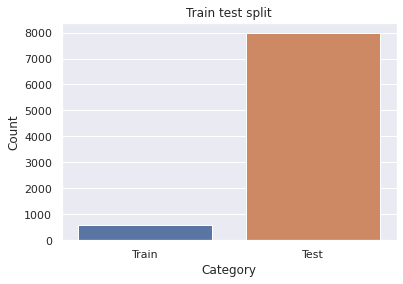

In [6]:
### Plot Train Test split ###

plt.figure(figsize=(6,4))
sns.barplot(['Train', 'Test'], [len(os.listdir(TRAIN_PATH)), len(os.listdir(TEST_PATH))]);
plt.title(f'Train test split', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

<span style="font-family:verdana; word-spacing:1.5px;">  This is a very unusual train test split for a kaggle competetion. Normally we would see at an 80:20 split, but here it is 1:16. The competition hosts are encouraging us to generate more data ourselves ([see discussion](https://www.kaggle.com/competitions/g2net-detecting-continuous-gravitational-waves/discussion/347052))

## <span style="font-family:verdana; word-spacing:1.5px;">  Labels
<span style="font-family:verdana; word-spacing:1.5px;">  Each data sample contains either **real or simulated noise** and possibly a **simulated continuous gravitational-wave signal** (CW). The task is to identify when a signal is present in the data (target=1)

<span style="font-family:verdana; word-spacing:1.5px;">  The `target_labels.csv` is a file containing the target labels; 1 if the data contains the presence of a gravitational wave, 0 otherwise. (Please note the presence of a small number of files labeled -1. Physicists are currently unable to determine the status of these files.)

In [7]:
labels_df = pd.read_csv(DATA_PATH/'train_labels.csv')
labels_df.head(5)

,id,target
0,001121a05,1
1,004f23b2d,1
2,00a6db666,1
3,00f36a6ac,1
4,010a387db,1


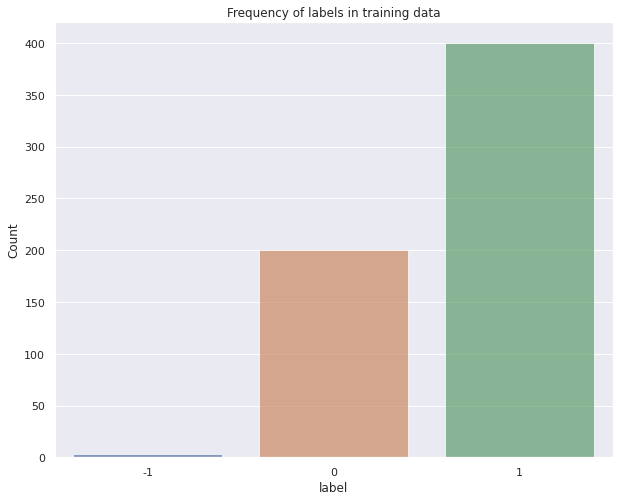

In [8]:
### Plot the distribution of labels ###
label_count  = labels_df['target'].value_counts()
plt.figure(figsize=(10,8))
sns.barplot(label_count.index, label_count.values, alpha=0.7)
plt.title(f'Frequency of labels in training data', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('label', fontsize=12)
plt.show()

### Sample submission:
`sample_submission.csv` - a sample submission file in the correct format; your task is, for each file in the test/ folder, to predict the probability between [0, 1] of it it containing a continuous gravitational wave signal.

In [9]:
pd.read_csv(DATA_PATH/'sample_submission.csv').head()

,id,target
0,00054c878,0.5
1,0007285a3,0.5
2,00076c5a6,0.5
3,001349290,0.5
4,001a52e92,0.5


# Plotting Spectograms 📊

In [10]:
### Helper functions to extract data and plot spectograms ###

def extract_data_from_hdf5(path, labels):
    '''
    Extracts data from hdf5 file and puts it into a dict. It also adds the label
    '''
    
    data = {}
    
    with h5py.File(path, "r") as f:

        ID_key = list(f.keys())[0]

        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])

        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])

        # Retrieve the Livingston decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
        
        # Get label from training labels if in training set
        data['label'] = labels.loc[labels.id==ID_key].target.item()
        
    return data
    
def plot_spectograms(data):
    '''
    Shows the real and imaginary amplitudes of the SFTs as spectograms for both detectors
    '''
    
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Label {data['label']}")

    for ind, detector in enumerate(['L1', 'H1']):
        ax[ind][0].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Real part")
        ax[ind][1].set(xlabel="Timestamps [GPS]",
                         ylabel="Frequency [Hz]",
                         title=f"{detector} - Imaginary part")
        
        
        c0 = ax[ind][0].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].real)
        c1 = ax[ind][1].pcolormesh(data[f"{detector}_ts"], data['freq'],
                                     data[f"{detector}_SFTs_amplitudes"].imag)
    
        fig.colorbar(c0, ax=ax[ind][0])
        fig.colorbar(c1, ax=ax[ind][1])
        
    plt.show()

#### <span style="font-family:verdana; word-spacing:1.5px;"> Lets plot some spectograms. One with a simulated signal and one without!

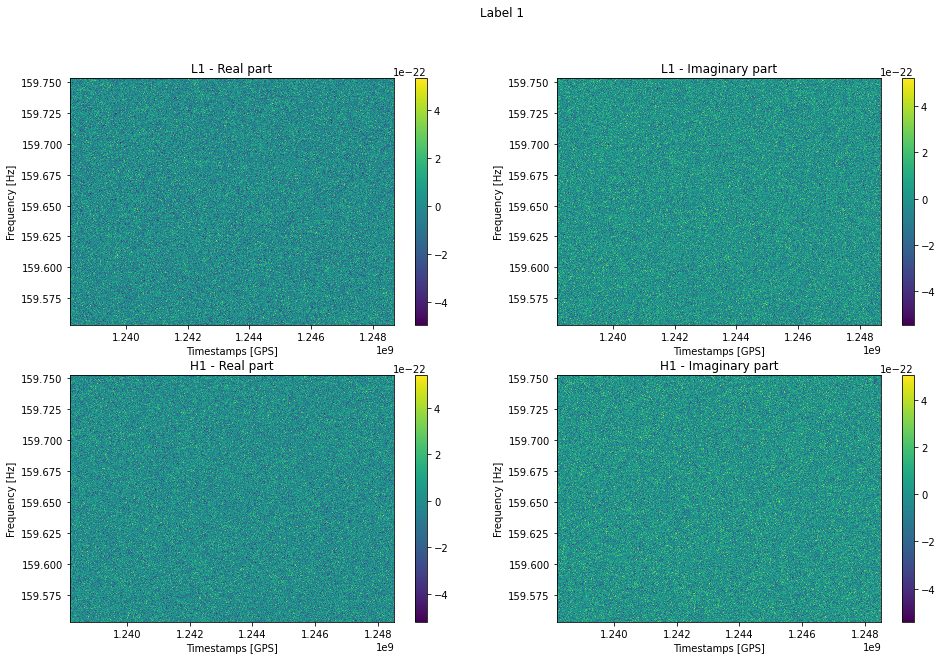

In [11]:
sns.reset_orig() # Reset seaborn theme (otherwise these plots come out red 😅)
data = extract_data_from_hdf5(train_example_with_signal_path, labels_df)
plot_spectograms(data)

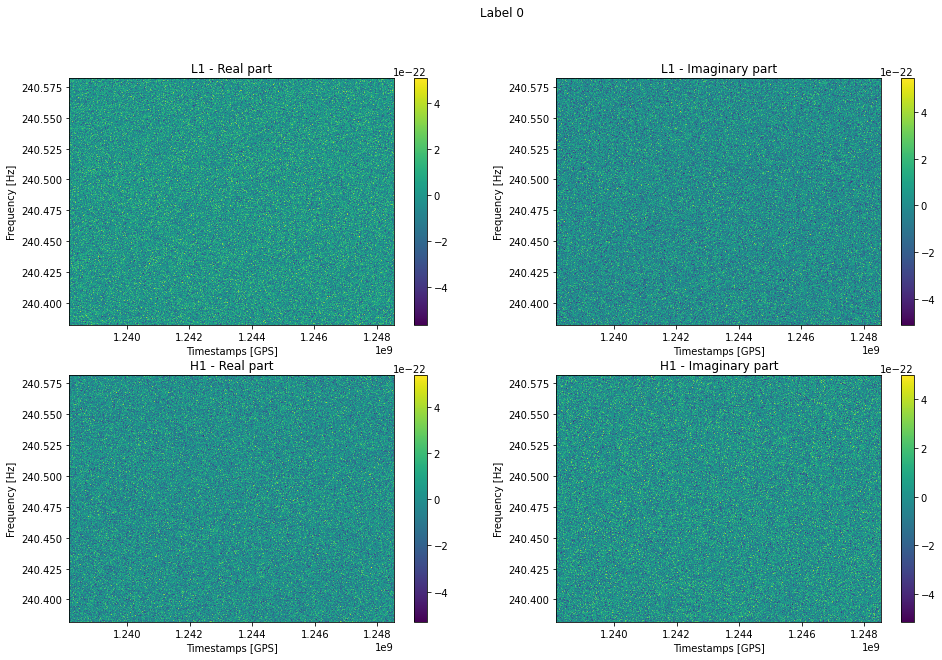

In [12]:
data = extract_data_from_hdf5(train_example_without_signal_path, labels_df)
plot_spectograms(data)

#### <span style="font-family:verdana; word-spacing:1.5px;"> Very hard to notice any difference at all 🤔

# What do the real and imaginary parts of a Short-time Fourier Transforms mean? 👻

# Timestamp analysis ⏱

Since the continuous gravitational wave is simulated I am not sure how the length of it is determined (it seems to be hard coded in the [generating signals nb](https://github.com/PyFstat/PyFstat/blob/ec86602bb2f93238492a7242ad90995f6654eab7/examples/tutorials/1_generating_signals.ipynb)). As a result, I assume that the timestamp data is relatively meaningless... for completness I will include a few plots :)

In [ ]:
### Extract timestamp data from training data ###

H1_timestamps, L1_timestamps, start_diff, labels, freq = ([] for i in range(5))

for p in tqdm(os.listdir(TRAIN_PATH), total=len(os.listdir(TRAIN_PATH))):
    id_ = p.split('.')[0]
    labels.append(labels_df.loc[labels_df.id==id_].target.item())
    data = extract_data_from_hdf5(DATA_PATH/'train'/p, labels_df)
    L1_timestamps.append(data['L1_ts'])
    H1_timestamps.append(data['H1_ts'])
    start_diff.append(data['L1_ts'][0] - data['H1_ts'][0])
    freq.append(data['freq'])

In [ ]:
df = pd.DataFrame({'label':labels, 'L1_timestamp_length':[len(i) for i in L1_timestamps], 'H1_timestamp_length':[len(i) for i in H1_timestamps], 'Differnce in start time between detectors':start_diff})
df = df[df.label!=-1]

In [ ]:
sns.set_theme()

fig, ax = plt.subplots(1,3, figsize=(24,8))
fig.suptitle(f"In the plots the distribution of timestamps for both classes are shown; 1 indicates a simulated CW present and 0 not present", fontsize=16)
sns.histplot(
        df, x="L1_timestamp_length", hue="label",
        stat="density", common_norm=False, bins=20, ax=ax[0], kde=True).set_title('Length of measurement for Livingston detector', fontsize=16);

sns.histplot(
        df, x="H1_timestamp_length", hue="label",
        stat="density", common_norm=False, bins=20, ax=ax[1], kde=True).set_title('Length of measurement for Hanford detector', fontsize=16);

sns.histplot(
        df, x="Differnce in start time between detectors", hue="label",
        stat="density", common_norm=False, bins=20, ax=ax[2], kde=True).set_title('Difference in starting timestamp between detectors', fontsize=16);

# Frequency analysis 📳

Do the detectors measure the same range of frequencies each time? No. The range varies but the minimum freq measured is ~50 Hz and the maximum is ~498 Hz

In [ ]:
plt.figure(figsize=(14,6))
sns.histplot(x=list(np.hstack(freq)), binwidth=20)
plt.title('Histogram of the range of Frequencies detected');
plt.xlabel('Frequency Hz')
plt.show()

# Generating more data ⚙️

Types of Noise
- Non-stationary noise
- Gaps
- Narrow instrumental artifacts
- Multiple detectors

Types of signal generation

# Baseline 📈

# Sample Submission

In [ ]:
samp_sub = pd.read_csv(DATA_PATH/'sample_submission.csv')
samp_sub['target'] = 0.55
samp_sub.to_csv('submission.csv', index=False)

# WIP :)